In [1]:
import os, sys, json
import argparse
import platform
import shutil

import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.nn.init import xavier_uniform_, zeros_
from PyQt5.QtWidgets import QApplication

from models import Braided_Classifier
from datasets import Train_Meta_Dataset, Val_Meta_Dataset, Test_Meta_Dataset, Random_Affine, ToTensor, Normalise, collate_fn
from meta_function import meta_loading

In [2]:
fileDir = "C:/fully_split_data/"
t1MapDir = "C:/T1_Maps/"
modelName = "Debug"
bSize = 4
normQ = False

modelDir = "./models/Braided_Net/{}/".format(modelName)
assert os.path.isdir(modelDir), "Model Directory is not found, please check your model name!"


figDir = "{}Test_Figures/".format(modelDir)
try:
    os.makedirs(figDir)
except FileExistsError as e:
    print(e, "This means you will be overwriting previous results!")

toT = ToTensor()

if normQ:
    norm = Normalise()
    trnsInTest = transforms.Compose([toT,norm])
else:
    trnsInTest = transforms.Compose([toT])

In [3]:
datasetTest = Test_Meta_Dataset(modelDir=modelDir,fileDir=fileDir,t1MapDir=t1MapDir,size=1000,transform=trnsInTest,load=True)
loaderTest = DataLoader(datasetTest,batch_size=bSize,shuffle=False,collate_fn=collate_fn,pin_memory=False)

batch = next(iter(loaderTest))
inpMetaSize = batch['Meta'].size()[1]
outSize = batch["Tag"].size()[1]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netB = Braided_Classifier(7,inpMetaSize,outSize,xDim=288,yDim=384,device=device)
modelDict = torch.load("{}model.pt".format(modelDir))
netB.load_state_dict(modelDict["state_dict"])
netB = netB.to(device)

testLen = datasetTest.__len__()

testLossCnt = 0

 [31198/31199]

TypeError: sigmoid() missing 1 required positional arguments: "input"

In [17]:
pred = np.zeros((1000,outSize))
y_test = np.zeros((1000,outSize))
with torch.no_grad():
    netB.train()
    for i,data in enumerate(loaderTest):
        inpData = data["Images"].to(device)
        eid = data["eid"]
        inpMeta = data["Meta"].to(device)
        y_test[i*bSize:(i+1)*bSize,:] = data["Tag"].numpy()

        out = netB(inpData,inpMeta)

        out = torch.sigmoid(out)

        pred[i*bSize:(i+1)*bSize,:] = out.cpu().numpy()

        sys.stdout.write("\r\tSubj {}/{}".format(i*bSize,testLen))

	Subj 996/1000

In [18]:
print(out,torch.sigmoid(out))

tensor([[3.9822e-02, 1.7420e-02, 3.2364e-03, 1.7017e-03, 2.9804e-03, 1.2375e-02,
         7.4685e-03, 5.5733e-03, 3.3136e-03, 2.6080e-03, 3.6183e-04, 4.6901e-03],
        [7.3612e-04, 1.0228e-03, 7.5884e-06, 1.9471e-06, 6.6062e-06, 4.9772e-04,
         2.9193e-05, 9.3619e-06, 4.0272e-06, 8.7326e-06, 2.3148e-07, 1.7518e-04],
        [5.1733e-03, 1.0499e-01, 1.8778e-03, 3.5532e-04, 6.8659e-04, 1.3623e-02,
         2.1045e-03, 6.7065e-04, 1.8203e-03, 2.3150e-03, 7.7159e-05, 1.0142e-02],
        [3.6743e-02, 2.4787e-02, 3.7934e-03, 1.7770e-03, 3.2455e-03, 1.3221e-02,
         8.6310e-03, 4.9607e-03, 3.6407e-03, 3.2528e-03, 4.0601e-04, 6.3063e-03]],
       device='cuda:0') tensor([[0.5100, 0.5044, 0.5008, 0.5004, 0.5007, 0.5031, 0.5019, 0.5014, 0.5008,
         0.5007, 0.5001, 0.5012],
        [0.5002, 0.5003, 0.5000, 0.5000, 0.5000, 0.5001, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000],
        [0.5013, 0.5262, 0.5005, 0.5001, 0.5002, 0.5034, 0.5005, 0.5002, 0.5005,
         0.5

c:\Users\shug4421\Meta_T1\venv\lib\site-packages\sklearn\metrics\_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
pdff35 Only one class present in y_true. ROC AUC score is not defined in that case.


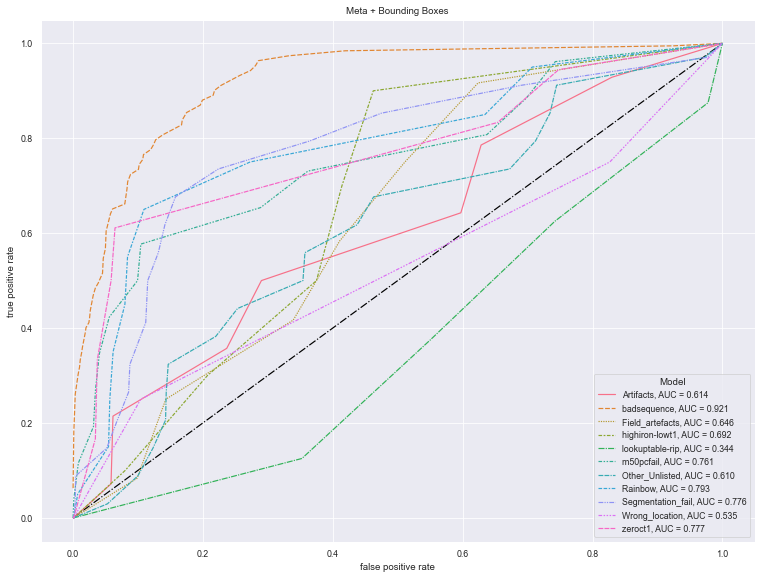

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
import pandas
import seaborn as sns

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

modelsArr = []
fprArr = []
tprArr = []

tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']

for i,name in enumerate(tagNames):
    try:
        fpr,tpr,_ = roc_curve(y_test[:,i],pred[:,i])
        auc_score = roc_auc_score(y_test[:,i],pred[:,i])

        event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

        modelsArr.extend(event)
        fprArr.extend(fpr)
        tprArr.extend(tpr)
    except ValueError as e:
        print(name,e)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)
df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Meta + Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
plt.show()

In [20]:
print(pred)

[[5.72743267e-02 1.56644329e-01 2.58164033e-02 ... 2.54105236e-02
  3.26363277e-03 4.58187312e-02]
 [5.09951357e-03 3.71872680e-03 1.54986206e-04 ... 1.32718327e-04
  1.51338372e-05 9.75291827e-04]
 [6.95650727e-02 1.01056501e-01 2.18683258e-02 ... 2.03460176e-02
  3.11278226e-03 3.38900611e-02]
 ...
 [7.36116664e-04 1.02279393e-03 7.58837086e-06 ... 8.73262616e-06
  2.31476847e-07 1.75177905e-04]
 [5.17330412e-03 1.04988828e-01 1.87783118e-03 ... 2.31499411e-03
  7.71590567e-05 1.01421811e-02]
 [3.67431305e-02 2.47874316e-02 3.79342469e-03 ... 3.25284386e-03
  4.06009785e-04 6.30629482e-03]]
